In [1]:
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from tensorflow.keras import layers

Using TensorFlow backend.


# Implemenations of the training loop, data augmentation and early stopping

In [2]:
(train_X,train_y), (test_X,test_y) = fashion_mnist.load_data()

In [3]:
X = np.concatenate((train_X, test_X))
y = np.concatenate((train_y, test_y))

In [4]:
label_list = ['T-shirt/top', 'Trouser', 'Pullover', 
              'Dress', 'Coat', 'Sandal', 'Shirt', 
              'Sneaker', 'Bag', 'Ankle boot']

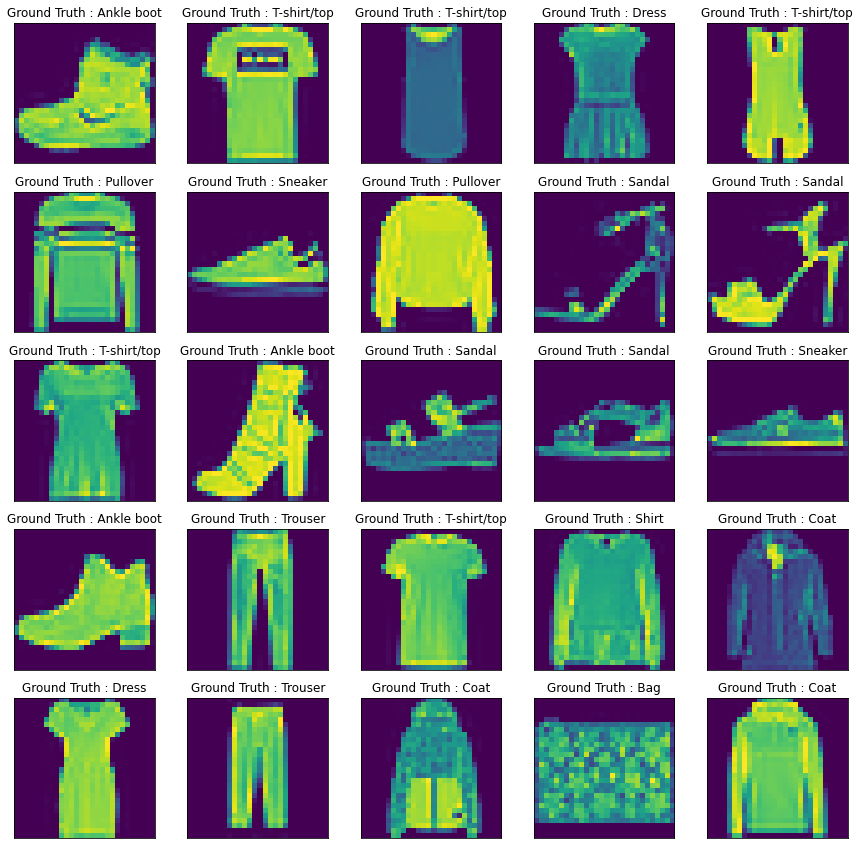

In [5]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.title("Ground Truth : {}".format(label_list[y[i]]))

plt.show()

In [6]:
X = X.reshape(70000, 28, 28, 1)

In [7]:
y = tf.one_hot(y, 10)

We want to randomly generate a training, validation and testing dataset from the original datasets X, y

In [8]:
# we want a (70, 15, 15) split
train_num = int(70000 * 0.7)
test_num = int(70000 * 0.15)
val_num = 70000 - train_num - test_num

In [9]:
train_X = X[:train_num]
val_X = X[train_num : val_num + train_num]
test_X = X[val_num + train_num:]

train_y = y[:train_num]
val_y = y[train_num : val_num + train_num]
test_y = y[val_num + train_num:]

In [37]:
# We want to augment our dataset for more robust results
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [38]:
datagen.fit(train_X)

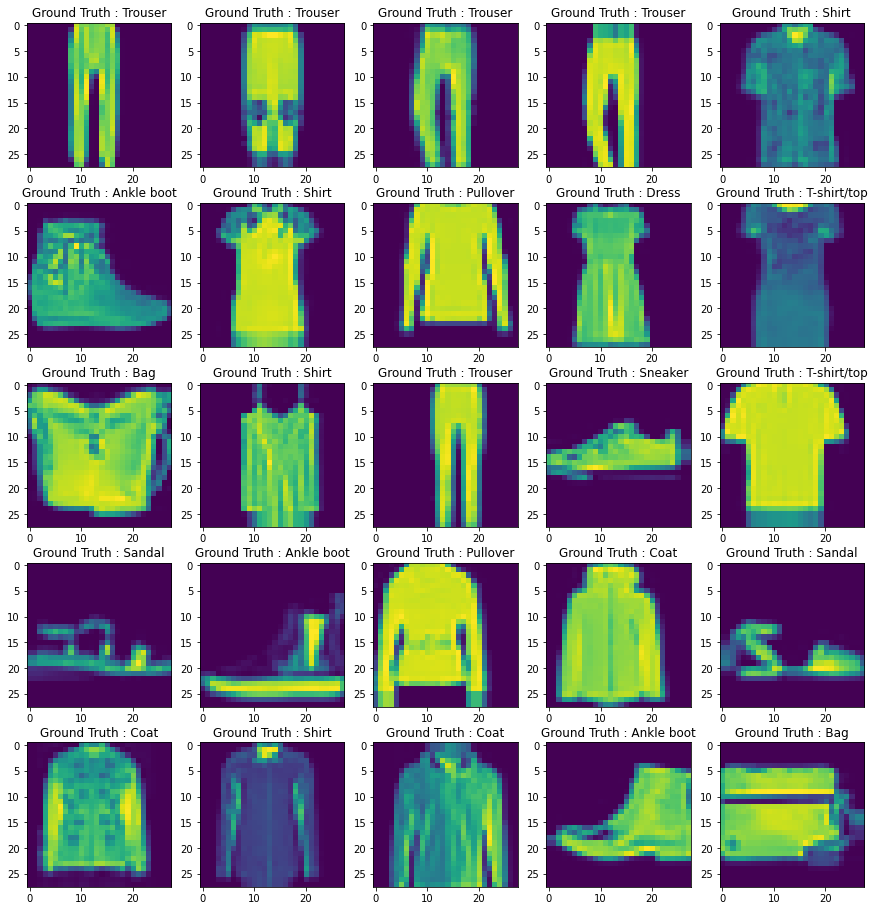

In [39]:
plt.figure(figsize=(15,16))
for X_batch, y_batch in datagen.flow(train_X, train_y, batch_size=25):
    for i in range(0, 25):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i].reshape(28, 28))
        plt.title("Ground Truth : {}".format(label_list[np.argmax(y_batch[i])]))


    # show the plot
    plt.show()
    break

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))

In [14]:
val_X = tf.cast(val_X, tf.float32)

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [16]:
# With references to https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
losses = []
val_losses = []

epochs = 10
for epoch in range(epochs):
    step = 0
    for (x_batch_train, y_batch_train) in datagen.flow(train_X, train_y, batch_size=64):
        
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)
            losses.append(loss_value)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 64))
        step += 1

        if step >= train_num // 64: break

Training loss (for one batch) at step 0: 2.3483
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5468
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.2099
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.0663
Seen so far: 38464 samples
Training loss (for one batch) at step 0: 1.1160
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.9372
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.0429
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.8037
Seen so far: 38464 samples
Training loss (for one batch) at step 0: 1.0484
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.8039
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.8119
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.7088
Seen so far: 38464 samples
Training loss (for one batch) at step 0: 0.9128
Seen so far: 64 samples
Training loss (for 

## Model evaluation

In [18]:
pred_train_y = model.predict(train_X)

In [21]:
train_labels = []
for i in range(0, len(pred_train_y)):
    train_labels.append(tf.keras.backend.eval(tf.argmax(train_y[i])))

In [24]:
pred_train_label = []
for i in range(0, len(pred_train_y)):
    pred_train_label.append(tf.keras.backend.eval(tf.argmax(pred_train_y[i])))

In [27]:
corr = 0
for i in range(0, len(pred_train_y)):
    if pred_train_label[i] == train_labels[i]:
        corr += 1
corr / train_num

0.7849795918367347

In [28]:
pred_test_y = model.predict(test_X)

In [29]:
test_labels = []
for i in range(0, len(pred_test_y)):
    test_labels.append(tf.keras.backend.eval(tf.argmax(test_y[i])))

In [30]:
pred_test_label = []
for i in range(0, len(pred_test_y)):
    pred_test_label.append(tf.keras.backend.eval(tf.argmax(pred_test_y[i])))

In [33]:
corr = 0
for i in range(0, len(pred_test_y)):
    if pred_test_label[i] == test_labels[i]:
        corr += 1
corr / test_num

0.7796190476190477

## Adding early stopping with data augmentation

In [25]:
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=3, restore_best_weights=True)

In [43]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_X, val_y))

In [44]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [46]:
model.compile(optimizer='SGD',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

history = model.fit(datagen.flow(train_X, train_y, batch_size=64), 
                    epochs=10, validation_data=(val_X, val_y), callbacks=[earlystop_callback])

Train for 766 steps, validate on 10500 samples
Epoch 1/10
766/766 [==============================] - 119s 156ms/step - loss: 0.6575 - accuracy: 0.7526 - val_loss: 0.6050 - val_accuracy: 0.7733
Epoch 2/10
766/766 [==============================] - 118s 154ms/step - loss: 0.5964 - accuracy: 0.7723 - val_loss: 0.5220 - val_accuracy: 0.8013
Epoch 3/10
766/766 [==============================] - 118s 154ms/step - loss: 0.5571 - accuracy: 0.7900 - val_loss: 0.5131 - val_accuracy: 0.8030
Epoch 4/10
766/766 [==============================] - 120s 157ms/step - loss: 0.5324 - accuracy: 0.7976 - val_loss: 0.4966 - val_accuracy: 0.8131
Epoch 5/10
766/766 [==============================] - 118s 154ms/step - loss: 0.5177 - accuracy: 0.8031 - val_loss: 0.4845 - val_accuracy: 0.8173
Epoch 6/10
766/766 [==============================] - 118s 155ms/step - loss: 0.5086 - accuracy: 0.8064 - val_loss: 0.4903 - val_accuracy: 0.8049


In [48]:
test_X = tf.cast(test_X, tf.float32)
pred_test_y = model.predict(test_X)

In [49]:
pred_test_label = []
for i in range(0, len(pred_test_y)):
    pred_test_label.append(tf.keras.backend.eval(tf.argmax(pred_test_y[i])))

In [50]:
corr = 0
for i in range(0, len(pred_test_y)):
    if pred_test_label[i] == test_labels[i]:
        corr += 1
corr / test_num

0.8165714285714286

## First attempt at usig early stopping

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [13]:
model.compile(optimizer='SGD',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=10, validation_data=(val_X, val_y), 
                    callbacks=[earlystop_callback], batch_size=32)

Train on 49000 samples, validate on 10500 samples
Epoch 1/10
49000/49000 [==============================] - 113s 2ms/sample - loss: 0.6224 - accuracy: 0.7725 - val_loss: 0.5081 - val_accuracy: 0.8122
Epoch 2/10
49000/49000 [==============================] - 112s 2ms/sample - loss: 0.4498 - accuracy: 0.8345 - val_loss: 0.4320 - val_accuracy: 0.8378
Epoch 3/10
49000/49000 [==============================] - 111s 2ms/sample - loss: 0.4080 - accuracy: 0.8489 - val_loss: 0.4482 - val_accuracy: 0.8278
Epoch 4/10
49000/49000 [==============================] - 111s 2ms/sample - loss: 0.3857 - accuracy: 0.8581 - val_loss: 0.3932 - val_accuracy: 0.8527
Epoch 5/10
49000/49000 [==============================] - 111s 2ms/sample - loss: 0.3688 - accuracy: 0.8643 - val_loss: 0.3794 - val_accuracy: 0.8574
Epoch 6/10
49000/49000 [==============================] - 111s 2ms/sample - loss: 0.3437 - accuracy: 0.8723 - val_loss: 0.4172 - val_accuracy: 0.8437
Epoch 7/10
49000/49000 [==========================

Basic model based on https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python, with parameter tweaking and early stopping

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
label_dict = ['T-shirt/top', 'Trouser', 'Pullover', 
              'Dress', 'Coat', 'Sandal', 'Shirt', 
              'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_X = train_images.reshape((60000, 28, 28, 1))
test_X = test_images.reshape((10000, 28, 28, 1))

train_X = tf.cast(train_X, tf.float32)
test_X = tf.cast(test_X, tf.float32)


train_y = tf.one_hot(train_labels, 10)
test_y = tf.one_hot(test_labels, 10)

In [22]:
# Previous: 4 layers, with 256, 128, 64, 32 (3, 3)
model = models.Sequential()
model.add(layers.Conv2D(64, (5, 5), activation='tanh', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='tanh'))
model.add(layers.Conv2D(16, (2, 2), activation='tanh'))
model.add(layers.Conv2D(8, (3, 3), activation='tanh'))

In [23]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))

In [26]:
model.compile(optimizer='SGD',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

history = model.fit(x=train_X, y=train_y, epochs=20, batch_size=32, validation_split=0.1, callbacks=[earlystop_callback])

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 235s 4ms/sample - loss: 0.5898 - accuracy: 0.7828 - val_loss: 0.4722 - val_accuracy: 0.8250
Epoch 2/20
54000/54000 [==============================] - 232s 4ms/sample - loss: 0.4096 - accuracy: 0.8508 - val_loss: 0.4630 - val_accuracy: 0.8292
Epoch 3/20
54000/54000 [==============================] - 229s 4ms/sample - loss: 0.3660 - accuracy: 0.8652 - val_loss: 0.3486 - val_accuracy: 0.8707
Epoch 4/20
54000/54000 [==============================] - 233s 4ms/sample - loss: 0.3363 - accuracy: 0.8746 - val_loss: 0.3320 - val_accuracy: 0.8775
Epoch 5/20
54000/54000 [==============================] - 232s 4ms/sample - loss: 0.3164 - accuracy: 0.8823 - val_loss: 0.3113 - val_accuracy: 0.8853
Epoch 6/20
54000/54000 [==============================] - 231s 4ms/sample - loss: 0.2993 - accuracy: 0.8898 - val_loss: 0.3116 - val_accuracy: 0.8848
Epoch 7/20
54000/54000 [===========================

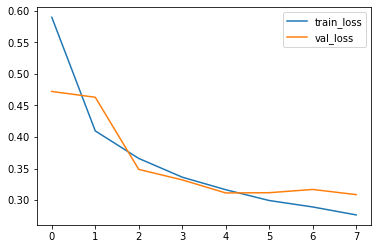

In [27]:
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")

plt.legend()

In [22]:
test_X.dtype

tf.float32

In [23]:
train_X.dtype

tf.float32

In [28]:
test_X = tf.cast(test_X, tf.float32)
pred_test_y = model.predict(x=test_X)

In [29]:
pred_test_label = []
for i in range(0, len(pred_test_y)):
    pred_test_label.append(tf.keras.backend.eval(tf.argmax(pred_test_y[i])))

In [30]:
(pred_test_label == test_labels).sum() / len(test_labels)

0.8782

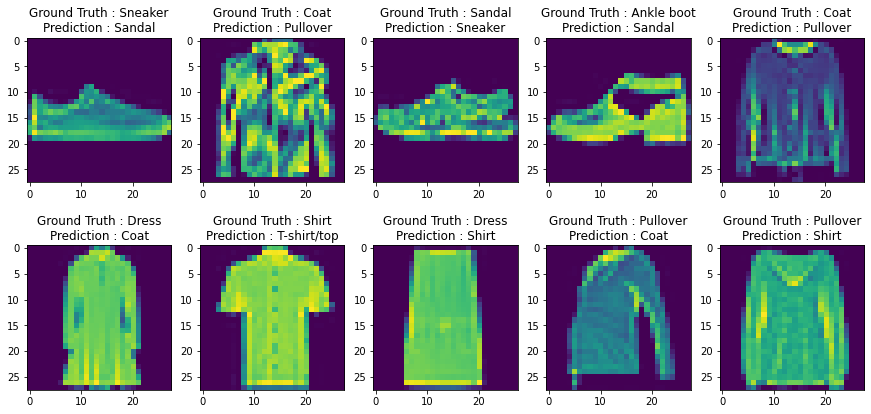

In [31]:
# What we got wrong
count = 0
i = 0

f, axs = plt.subplots(2, 5)
f.set_figheight(7)
f.set_figwidth(15)

while count < 10:
    if test_labels[i] != pred_test_label[i]:
        axs[count // 5][count % 5].imshow(test_images[i])
        axs[count // 5][count % 5].set_title("Ground Truth : {}".format(label_dict[test_labels[i]]) + 
                                             '\n' + "Prediction : {}".format(label_dict[pred_test_label[i]]))
        count += 1
    i += 1

plt.show()

In [ ]:
'''
TODO:
- Implement training
- Tune the model
- Transform training data for performance
- Show CNN filters at each level
- Validation / testing split
'''